In [796]:
import pandas as pd 
import numpy as np
import datetime
from dateutil.relativedelta import  relativedelta
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split


In [797]:
# Read the sheets from the data files:
plants= pd.read_excel("Data.xlsx",0)
flight_dates= pd.read_excel("Data.xlsx", 1)
planting= pd.read_excel("Data.xlsx",2)
weather= pd.read_excel("Data.xlsx",3)

In [798]:
# Rename the columns and delete the spaces from the column names:
for df in [plants, flight_dates,planting, weather]:
    df.columns = df.columns.str.replace(' ','_')
    
weather.rename(columns={weather.columns[0]: 'Date'},inplace=True)
planting.rename(columns={"Planting_Batch":"Batch_Number"},inplace=True)

In [799]:
# Drop any row in 'Remove' column that has a value:
plants = plants[plants['Remove'].isna()]

# Drop the not used columns in features:
plants.drop(['Diameter_Ratio', 'Density_(kg/L)', 'Remove'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [800]:
# Print columns for each sheet:
sheets = ['Plants', 'Flight Dates', 'Planting', 'Weather']
for i, j in enumerate([plants, flight_dates, planting, weather]):
    print('*****', sheets[i], '*****')
    print(j.columns.tolist())
    print()

***** Plants *****
['Batch_Number', 'Plant_Date', 'Class', 'Fresh_Weight_(g)', 'Head_Weight_(g)', 'Radial_Diameter_(mm)', 'Polar_Diameter_(mm)', 'Leaves', 'Leaf_Area_(cm^2)', 'Square_ID', 'Check_Date', 'Flight_Date']

***** Flight Dates *****
['Batch_Number', 'Flight_Date']

***** Planting *****
['Crop', 'Column2', 'Column3', 'Plant_Date', 'Column1', 'Region', 'Column4', 'Batch_Number', 'Volume_Planted', 'Planting_Wk']

***** Weather *****
['Date', 'Solar_Radiation_[avg]', 'Precipitation_[sum]', 'Wind_Speed_[avg]', 'Wind_Speed_[max]', 'Battery_Voltage_[last]', 'Leaf_Wetness_[time]', 'Air_Temperature_[avg]', 'Air_Temperature_[max]', 'Air_Temperature_[min]', 'Relative_Humidity_[avg]', 'Dew_Point_[avg]', 'Dew_Point_[min]', 'ET0_[result]']



In [801]:
# Describe each sheet:
for i, j in enumerate([plants, flight_dates, planting, weather]):
    print('*****', sheets[i], '*****')
    print(j.describe())
    print()

***** Plants *****
       Batch_Number        Class  Fresh_Weight_(g)  Head_Weight_(g)  \
count   4789.000000  4789.000000       4788.000000      4684.000000   
mean     622.812696     2.970558        471.527074       182.992955   
std       92.948267     1.424723        296.590346       187.813480   
min      402.000000     1.000000          0.632000         0.000000   
25%      582.000000     2.000000        230.000000        27.000000   
50%      647.000000     3.000000        430.000000       113.000000   
75%      698.000000     4.000000        680.250000       305.000000   
max      739.000000     5.000000       1978.000000       998.000000   

       Radial_Diameter_(mm)  Polar_Diameter_(mm)      Leaves  \
count           4684.000000          4684.000000  100.000000   
mean             100.161187            97.231853   17.070000   
std               41.961920            34.188622   28.063512   
min                0.000000             0.000000    7.000000   
25%               66.

In [802]:
# Find Nulls columns percentage:
for i, j in enumerate([plants, flight_dates, planting, weather]):
    print('*****', sheets[i], '*****')
    print(round(j.isna().sum()/j.shape[0]*100))
    print()

***** Plants *****
Batch_Number             0.0
Plant_Date               4.0
Class                    0.0
Fresh_Weight_(g)         0.0
Head_Weight_(g)          2.0
Radial_Diameter_(mm)     2.0
Polar_Diameter_(mm)      2.0
Leaves                  98.0
Leaf_Area_(cm^2)         0.0
Square_ID                0.0
Check_Date               0.0
Flight_Date             90.0
dtype: float64

***** Flight Dates *****
Batch_Number    0.0
Flight_Date     0.0
dtype: float64

***** Planting *****
Crop                0.0
Column2           100.0
Column3           100.0
Plant_Date          0.0
Column1           100.0
Region              0.0
Column4           100.0
Batch_Number        0.0
Volume_Planted      0.0
Planting_Wk         0.0
dtype: float64

***** Weather *****
Date                       0.0
Solar_Radiation_[avg]      0.0
Precipitation_[sum]        0.0
Wind_Speed_[avg]           0.0
Wind_Speed_[max]           0.0
Battery_Voltage_[last]     0.0
Leaf_Wetness_[time]        0.0
Air_Temperature_[avg] 

In [803]:
# Drop columns that have more than 95% nulls:
for i, j in enumerate([plants, flight_dates, planting, weather]):
    print('*****', sheets[i], '*****')
    per = round(j.isna().sum()/j.shape[0]*100)
    drop_cols = per[per >= 95].index.tolist()
    j.drop(drop_cols, axis=1, inplace=True)
    print(drop_cols)
    print()

***** Plants *****
['Leaves']

***** Flight Dates *****
[]

***** Planting *****
['Column2', 'Column3', 'Column1', 'Column4']

***** Weather *****
[]



In [804]:
# Merge the plants and planting sheets together, based on the Batch Number:
plants = plants.merge(planting, on=['Batch_Number', 'Plant_Date'], how='left')

In [805]:
# Find the Batches that don't have a Plant Date:
plants[plants['Plant_Date'].isna()]['Batch_Number'].unique()

array([691, 693, 694, 695, 699, 698])

In [806]:
# Find the number of missing Flight Dates:
print('Total Number:',plants.shape[0])
print('Missing Flight Dates:', plants['Flight_Date'].isna().sum())

Total Number: 4789
Missing Flight Dates: 4321


In [807]:
# Get the missing Flight Dates from flight_date sheet:
plants = plants.merge(flight_dates, on='Batch_Number', how='left')
plants['Flight_Date']=plants.Flight_Date_x.combine_first(plants.Flight_Date_y)
plants.drop(columns=['Flight_Date_x','Flight_Date_y'], inplace=True)

In [808]:
# Find the number of missing Flight Dates:
print('Total Number:',plants.shape[0])
print('Missing Flight Dates:', plants['Flight_Date'].isna().sum())

Total Number: 4789
Missing Flight Dates: 1455


In [809]:
plants.columns

Index(['Batch_Number', 'Plant_Date', 'Class', 'Fresh_Weight_(g)',
       'Head_Weight_(g)', 'Radial_Diameter_(mm)', 'Polar_Diameter_(mm)',
       'Leaf_Area_(cm^2)', 'Square_ID', 'Check_Date', 'Crop', 'Region',
       'Volume_Planted', 'Planting_Wk', 'Flight_Date'],
      dtype='object')

In [810]:
plants['Check_Date']=pd.to_datetime(plants['Check_Date'])
plants['Flight_Date']=pd.to_datetime(plants['Flight_Date'])
plants['Plant_Date']=pd.to_datetime(plants['Plant_Date'])


In [811]:
# Create two new features based on days between plant date and flight date/check date
plants['days_to_flight_check'] =(plants['Flight_Date'] - plants['Plant_Date'])/np.timedelta64(1,'D')
plants['days_to_manual_check'] =(plants['Check_Date'] - plants['Plant_Date'])/np.timedelta64(1,'D')
plants


,Batch_Number,Plant_Date,Class,Fresh_Weight_(g),Head_Weight_(g),Radial_Diameter_(mm),Polar_Diameter_(mm),Leaf_Area_(cm^2),Square_ID,Check_Date,Crop,Region,Volume_Planted,Planting_Wk,Flight_Date,days_to_flight_check,days_to_manual_check
0,402,2020-04-11,3,15.0,NaN,NaN,NaN,185.0,208,2020-04-30,3.0,0.0,155232.0,15.0,2020-04-30,19.0,19.0
1,402,2020-04-11,4,15.0,NaN,NaN,NaN,156.0,208,2020-04-30,3.0,0.0,155232.0,15.0,2020-04-30,19.0,19.0
2,402,2020-04-11,1,16.0,NaN,NaN,NaN,137.0,208,2020-04-30,3.0,0.0,155232.0,15.0,2020-04-30,19.0,19.0
3,402,2020-04-11,3,15.0,NaN,NaN,NaN,225.0,208,2020-04-30,3.0,0.0,155232.0,15.0,2020-04-30,19.0,19.0
4,402,2020-04-11,3,15.0,NaN,NaN,NaN,157.0,208,2020-04-30,3.0,0.0,155232.0,15.0,2020-04-30,19.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,738,2020-08-27,4,284.0,12.0,50.0,55.0,430.0,1172,2020-10-20,3.0,0.0,265608.0,35.0,NaT,NaN,54.0
4785,738,2020-08-27,5,199.0,8.0,45.0,85.0,358.0,1172,2020-10-20,3.0,0.0,265608.0,35.0,NaT,NaN,54.0
4786,738,2020-08-27,3,280.0,23.0,60.0,80.0,417.0,1172,2020-10-20,3.0,0.0,265608.0,35.0,NaT,NaN,54.0
4787,738,2020-08-27,4,247.0,10.0,45.0,80.0,413.0,1172,2020-10-20,3.0,0.0,265608.0,35.0,NaT,NaN,54.0


In [812]:
plants['Last_Year']= plants["Flight_Date"] - pd.Timedelta(days=366) 
plants


,Batch_Number,Plant_Date,Class,Fresh_Weight_(g),Head_Weight_(g),Radial_Diameter_(mm),Polar_Diameter_(mm),Leaf_Area_(cm^2),Square_ID,Check_Date,Crop,Region,Volume_Planted,Planting_Wk,Flight_Date,days_to_flight_check,days_to_manual_check,Last_Year
0,402,2020-04-11,3,15.0,NaN,NaN,NaN,185.0,208,2020-04-30,3.0,0.0,155232.0,15.0,2020-04-30,19.0,19.0,2019-04-30
1,402,2020-04-11,4,15.0,NaN,NaN,NaN,156.0,208,2020-04-30,3.0,0.0,155232.0,15.0,2020-04-30,19.0,19.0,2019-04-30
2,402,2020-04-11,1,16.0,NaN,NaN,NaN,137.0,208,2020-04-30,3.0,0.0,155232.0,15.0,2020-04-30,19.0,19.0,2019-04-30
3,402,2020-04-11,3,15.0,NaN,NaN,NaN,225.0,208,2020-04-30,3.0,0.0,155232.0,15.0,2020-04-30,19.0,19.0,2019-04-30
4,402,2020-04-11,3,15.0,NaN,NaN,NaN,157.0,208,2020-04-30,3.0,0.0,155232.0,15.0,2020-04-30,19.0,19.0,2019-04-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,738,2020-08-27,4,284.0,12.0,50.0,55.0,430.0,1172,2020-10-20,3.0,0.0,265608.0,35.0,NaT,NaN,54.0,NaT
4785,738,2020-08-27,5,199.0,8.0,45.0,85.0,358.0,1172,2020-10-20,3.0,0.0,265608.0,35.0,NaT,NaN,54.0,NaT
4786,738,2020-08-27,3,280.0,23.0,60.0,80.0,417.0,1172,2020-10-20,3.0,0.0,265608.0,35.0,NaT,NaN,54.0,NaT
4787,738,2020-08-27,4,247.0,10.0,45.0,80.0,413.0,1172,2020-10-20,3.0,0.0,265608.0,35.0,NaT,NaN,54.0,NaT


In [813]:
plants=plants.merge(weather, left_on='Last_Year', right_on='Date', how='left')
plants


,Batch_Number,Plant_Date,Class,Fresh_Weight_(g),Head_Weight_(g),Radial_Diameter_(mm),Polar_Diameter_(mm),Leaf_Area_(cm^2),Square_ID,Check_Date,...,Wind_Speed_[max],Battery_Voltage_[last],Leaf_Wetness_[time],Air_Temperature_[avg],Air_Temperature_[max],Air_Temperature_[min],Relative_Humidity_[avg],Dew_Point_[avg],Dew_Point_[min],ET0_[result]
0,402,2020-04-11,3,15.0,NaN,NaN,NaN,185.0,208,2020-04-30,...,2.2,6718.0,0.0,8.07,15.36,0.35,88.0,5.7,0.2,1.9
1,402,2020-04-11,4,15.0,NaN,NaN,NaN,156.0,208,2020-04-30,...,2.2,6718.0,0.0,8.07,15.36,0.35,88.0,5.7,0.2,1.9
2,402,2020-04-11,1,16.0,NaN,NaN,NaN,137.0,208,2020-04-30,...,2.2,6718.0,0.0,8.07,15.36,0.35,88.0,5.7,0.2,1.9
3,402,2020-04-11,3,15.0,NaN,NaN,NaN,225.0,208,2020-04-30,...,2.2,6718.0,0.0,8.07,15.36,0.35,88.0,5.7,0.2,1.9
4,402,2020-04-11,3,15.0,NaN,NaN,NaN,157.0,208,2020-04-30,...,2.2,6718.0,0.0,8.07,15.36,0.35,88.0,5.7,0.2,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,738,2020-08-27,4,284.0,12.0,50.0,55.0,430.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4785,738,2020-08-27,5,199.0,8.0,45.0,85.0,358.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4786,738,2020-08-27,3,280.0,23.0,60.0,80.0,417.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4787,738,2020-08-27,4,247.0,10.0,45.0,80.0,413.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [814]:
plants=plants.merge(weather, left_on='Flight_Date', right_on='Date', how='left')
plants

,Batch_Number,Plant_Date,Class,Fresh_Weight_(g),Head_Weight_(g),Radial_Diameter_(mm),Polar_Diameter_(mm),Leaf_Area_(cm^2),Square_ID,Check_Date,...,Wind_Speed_[max]_y,Battery_Voltage_[last]_y,Leaf_Wetness_[time]_y,Air_Temperature_[avg]_y,Air_Temperature_[max]_y,Air_Temperature_[min]_y,Relative_Humidity_[avg]_y,Dew_Point_[avg]_y,Dew_Point_[min]_y,ET0_[result]_y
0,402,2020-04-11,3,15.0,NaN,NaN,NaN,185.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
1,402,2020-04-11,4,15.0,NaN,NaN,NaN,156.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
2,402,2020-04-11,1,16.0,NaN,NaN,NaN,137.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
3,402,2020-04-11,3,15.0,NaN,NaN,NaN,225.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
4,402,2020-04-11,3,15.0,NaN,NaN,NaN,157.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,738,2020-08-27,4,284.0,12.0,50.0,55.0,430.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4785,738,2020-08-27,5,199.0,8.0,45.0,85.0,358.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4786,738,2020-08-27,3,280.0,23.0,60.0,80.0,417.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4787,738,2020-08-27,4,247.0,10.0,45.0,80.0,413.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [815]:
plants.columns = plants.columns.str.replace('_x','_Last_Year')
plants.columns = plants.columns.str.replace('_y','_Flight_Year')


In [816]:
plants

,Batch_Number,Plant_Date,Class,Fresh_Weight_(g),Head_Weight_(g),Radial_Diameter_(mm),Polar_Diameter_(mm),Leaf_Area_(cm^2),Square_ID,Check_Date,...,Wind_Speed_[max]_Flight_Year,Battery_Voltage_[last]_Flight_Year,Leaf_Wetness_[time]_Flight_Year,Air_Temperature_[avg]_Flight_Year,Air_Temperature_[max]_Flight_Year,Air_Temperature_[min]_Flight_Year,Relative_Humidity_[avg]_Flight_Year,Dew_Point_[avg]_Flight_Year,Dew_Point_[min]_Flight_Year,ET0_[result]_Flight_Year
0,402,2020-04-11,3,15.0,NaN,NaN,NaN,185.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
1,402,2020-04-11,4,15.0,NaN,NaN,NaN,156.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
2,402,2020-04-11,1,16.0,NaN,NaN,NaN,137.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
3,402,2020-04-11,3,15.0,NaN,NaN,NaN,225.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
4,402,2020-04-11,3,15.0,NaN,NaN,NaN,157.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,738,2020-08-27,4,284.0,12.0,50.0,55.0,430.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4785,738,2020-08-27,5,199.0,8.0,45.0,85.0,358.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4786,738,2020-08-27,3,280.0,23.0,60.0,80.0,417.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4787,738,2020-08-27,4,247.0,10.0,45.0,80.0,413.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [817]:
# Delete records with null flight time, planet date:
plants[['Flight_Date', 'Plant_Date', 'Radial_Diameter_(mm)', 'Polar_Diameter_(mm)', 'Head_Weight_(g)']].dropna(inplace=True)
plants

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Batch_Number,Plant_Date,Class,Fresh_Weight_(g),Head_Weight_(g),Radial_Diameter_(mm),Polar_Diameter_(mm),Leaf_Area_(cm^2),Square_ID,Check_Date,...,Wind_Speed_[max]_Flight_Year,Battery_Voltage_[last]_Flight_Year,Leaf_Wetness_[time]_Flight_Year,Air_Temperature_[avg]_Flight_Year,Air_Temperature_[max]_Flight_Year,Air_Temperature_[min]_Flight_Year,Relative_Humidity_[avg]_Flight_Year,Dew_Point_[avg]_Flight_Year,Dew_Point_[min]_Flight_Year,ET0_[result]_Flight_Year
0,402,2020-04-11,3,15.0,NaN,NaN,NaN,185.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
1,402,2020-04-11,4,15.0,NaN,NaN,NaN,156.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
2,402,2020-04-11,1,16.0,NaN,NaN,NaN,137.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
3,402,2020-04-11,3,15.0,NaN,NaN,NaN,225.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
4,402,2020-04-11,3,15.0,NaN,NaN,NaN,157.0,208,2020-04-30,...,7.4,6894.0,20.0,9.24,13.07,6.03,89.02,7.3,5.7,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,738,2020-08-27,4,284.0,12.0,50.0,55.0,430.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4785,738,2020-08-27,5,199.0,8.0,45.0,85.0,358.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4786,738,2020-08-27,3,280.0,23.0,60.0,80.0,417.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4787,738,2020-08-27,4,247.0,10.0,45.0,80.0,413.0,1172,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [818]:
# Fill nulls with average:
plants.fillna(plants.mean(), inplace=True)
plants

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,Batch_Number,Plant_Date,Class,Fresh_Weight_(g),Head_Weight_(g),Radial_Diameter_(mm),Polar_Diameter_(mm),Leaf_Area_(cm^2),Square_ID,Check_Date,...,Wind_Speed_[max]_Flight_Year,Battery_Voltage_[last]_Flight_Year,Leaf_Wetness_[time]_Flight_Year,Air_Temperature_[avg]_Flight_Year,Air_Temperature_[max]_Flight_Year,Air_Temperature_[min]_Flight_Year,Relative_Humidity_[avg]_Flight_Year,Dew_Point_[avg]_Flight_Year,Dew_Point_[min]_Flight_Year,ET0_[result]_Flight_Year
0,402,2020-04-11,3,15.0,182.992955,100.161187,97.231853,185.0,208,2020-04-30,...,7.400000,6894.000000,20.000000,9.240000,13.070000,6.030000,89.02000,7.300000,5.700000,1.900000
1,402,2020-04-11,4,15.0,182.992955,100.161187,97.231853,156.0,208,2020-04-30,...,7.400000,6894.000000,20.000000,9.240000,13.070000,6.030000,89.02000,7.300000,5.700000,1.900000
2,402,2020-04-11,1,16.0,182.992955,100.161187,97.231853,137.0,208,2020-04-30,...,7.400000,6894.000000,20.000000,9.240000,13.070000,6.030000,89.02000,7.300000,5.700000,1.900000
3,402,2020-04-11,3,15.0,182.992955,100.161187,97.231853,225.0,208,2020-04-30,...,7.400000,6894.000000,20.000000,9.240000,13.070000,6.030000,89.02000,7.300000,5.700000,1.900000
4,402,2020-04-11,3,15.0,182.992955,100.161187,97.231853,157.0,208,2020-04-30,...,7.400000,6894.000000,20.000000,9.240000,13.070000,6.030000,89.02000,7.300000,5.700000,1.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,738,2020-08-27,4,284.0,12.000000,50.000000,55.000000,430.0,1172,2020-10-20,...,5.365927,6870.430114,56.840132,16.486854,21.849157,10.600006,81.48482,12.577445,9.240852,3.345141
4785,738,2020-08-27,5,199.0,8.000000,45.000000,85.000000,358.0,1172,2020-10-20,...,5.365927,6870.430114,56.840132,16.486854,21.849157,10.600006,81.48482,12.577445,9.240852,3.345141
4786,738,2020-08-27,3,280.0,23.000000,60.000000,80.000000,417.0,1172,2020-10-20,...,5.365927,6870.430114,56.840132,16.486854,21.849157,10.600006,81.48482,12.577445,9.240852,3.345141
4787,738,2020-08-27,4,247.0,10.000000,45.000000,80.000000,413.0,1172,2020-10-20,...,5.365927,6870.430114,56.840132,16.486854,21.849157,10.600006,81.48482,12.577445,9.240852,3.345141


In [819]:
# FInal Dataframe
X = plants.drop(['Radial_Diameter_(mm)', 'Polar_Diameter_(mm)', 'Head_Weight_(g)'], axis=1)
y = plants[['Radial_Diameter_(mm)', 'Polar_Diameter_(mm)', 'Head_Weight_(g)']]


In [820]:
X

,Batch_Number,Plant_Date,Class,Fresh_Weight_(g),Leaf_Area_(cm^2),Square_ID,Check_Date,Crop,Region,Volume_Planted,...,Wind_Speed_[max]_Flight_Year,Battery_Voltage_[last]_Flight_Year,Leaf_Wetness_[time]_Flight_Year,Air_Temperature_[avg]_Flight_Year,Air_Temperature_[max]_Flight_Year,Air_Temperature_[min]_Flight_Year,Relative_Humidity_[avg]_Flight_Year,Dew_Point_[avg]_Flight_Year,Dew_Point_[min]_Flight_Year,ET0_[result]_Flight_Year
0,402,2020-04-11,3,15.0,185.0,208,2020-04-30,3.0,0.0,155232.0,...,7.400000,6894.000000,20.000000,9.240000,13.070000,6.030000,89.02000,7.300000,5.700000,1.900000
1,402,2020-04-11,4,15.0,156.0,208,2020-04-30,3.0,0.0,155232.0,...,7.400000,6894.000000,20.000000,9.240000,13.070000,6.030000,89.02000,7.300000,5.700000,1.900000
2,402,2020-04-11,1,16.0,137.0,208,2020-04-30,3.0,0.0,155232.0,...,7.400000,6894.000000,20.000000,9.240000,13.070000,6.030000,89.02000,7.300000,5.700000,1.900000
3,402,2020-04-11,3,15.0,225.0,208,2020-04-30,3.0,0.0,155232.0,...,7.400000,6894.000000,20.000000,9.240000,13.070000,6.030000,89.02000,7.300000,5.700000,1.900000
4,402,2020-04-11,3,15.0,157.0,208,2020-04-30,3.0,0.0,155232.0,...,7.400000,6894.000000,20.000000,9.240000,13.070000,6.030000,89.02000,7.300000,5.700000,1.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,738,2020-08-27,4,284.0,430.0,1172,2020-10-20,3.0,0.0,265608.0,...,5.365927,6870.430114,56.840132,16.486854,21.849157,10.600006,81.48482,12.577445,9.240852,3.345141
4785,738,2020-08-27,5,199.0,358.0,1172,2020-10-20,3.0,0.0,265608.0,...,5.365927,6870.430114,56.840132,16.486854,21.849157,10.600006,81.48482,12.577445,9.240852,3.345141
4786,738,2020-08-27,3,280.0,417.0,1172,2020-10-20,3.0,0.0,265608.0,...,5.365927,6870.430114,56.840132,16.486854,21.849157,10.600006,81.48482,12.577445,9.240852,3.345141
4787,738,2020-08-27,4,247.0,413.0,1172,2020-10-20,3.0,0.0,265608.0,...,5.365927,6870.430114,56.840132,16.486854,21.849157,10.600006,81.48482,12.577445,9.240852,3.345141


In [821]:
y

,Radial_Diameter_(mm),Polar_Diameter_(mm),Head_Weight_(g)
0,100.161187,97.231853,182.992955
1,100.161187,97.231853,182.992955
2,100.161187,97.231853,182.992955
3,100.161187,97.231853,182.992955
4,100.161187,97.231853,182.992955
...,...,...,...
4784,50.000000,55.000000,12.000000
4785,45.000000,85.000000,8.000000
4786,60.000000,80.000000,23.000000
4787,45.000000,80.000000,10.000000


In [822]:
X.drop(['Plant_Date', 'Check_Date', 'Flight_Date', 'Last_Year', 'Date_Last_Year', 'Date_Flight_Year'],axis=1, inplace=True)
# Split the data:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print('Full data size:', X.shape, y.shape)
print('Train Data Size:', X_train.shape, y_train.shape)
print('Test Data Size:', X_test.shape, y_test.shape)




Full data size: (4789, 37) (4789, 3)
Train Data Size: (3831, 37) (3831, 3)
Test Data Size: (958, 37) (958, 3)


In [823]:
def plot_fig(true_value, predicted_value, title):
    plt.figure(figsize=(10,10))
    plt.scatter(true_value, predicted_value, c='crimson')

    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.title(title)
    plt.show()

In [824]:
# Linear regression model:
# define model:
model_linear = LinearRegression()
# Fit model
model_linear.fit(X_train, y_train)
#calculate the coefficient of determination
r_sq = model_linear.score(X_train, y_train)
print('coefficient of determination:', r_sq)
# make a prediction
yhat = model_linear.predict(X_test)
print('predicted response:', yhat, sep='\n')




coefficient of determination: 0.7968780300893382
predicted response:
[[142.67763616 116.42609328 461.91770185]
 [143.86716415 137.84156668 332.87830179]
 [ 82.689056    75.61493509 106.61947347]
 ...
 [ 86.18210696  97.68324189  87.65636553]
 [ 95.89032742 102.07556956 108.90732092]
 [148.01848376 132.84839612 390.41942437]]


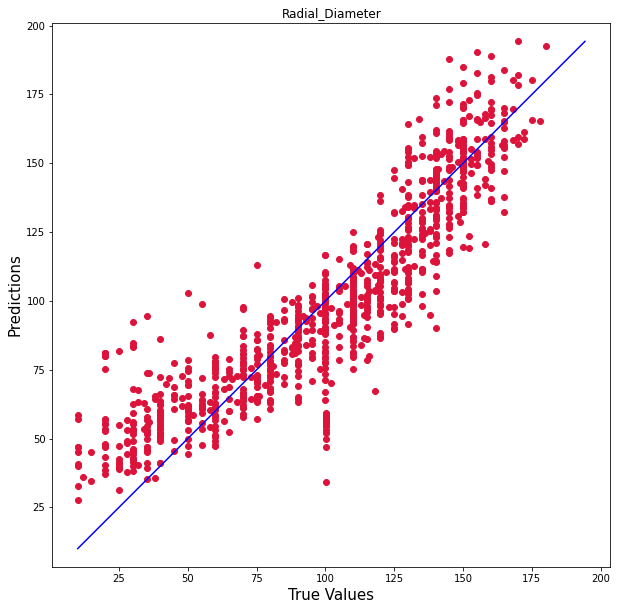

In [825]:
plot_fig(y_test.to_numpy().T[0], yhat.T[0],'Radial_Diameter')

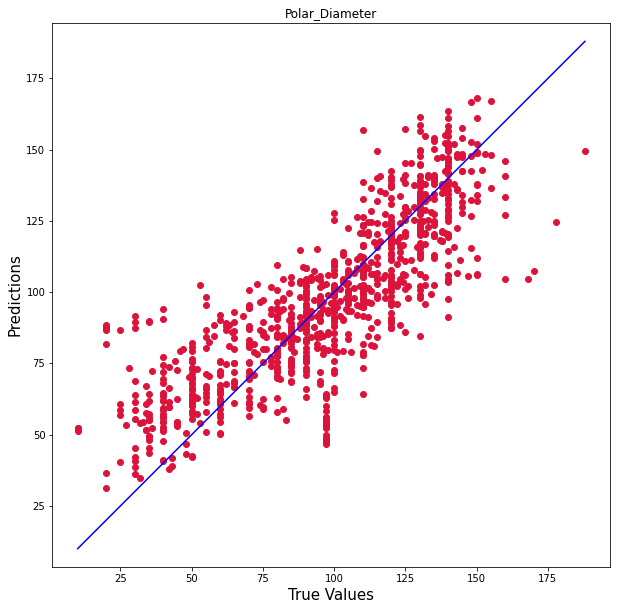

In [826]:
plot_fig(y_test.to_numpy().T[1], yhat.T[1], 'Polar_Diameter')


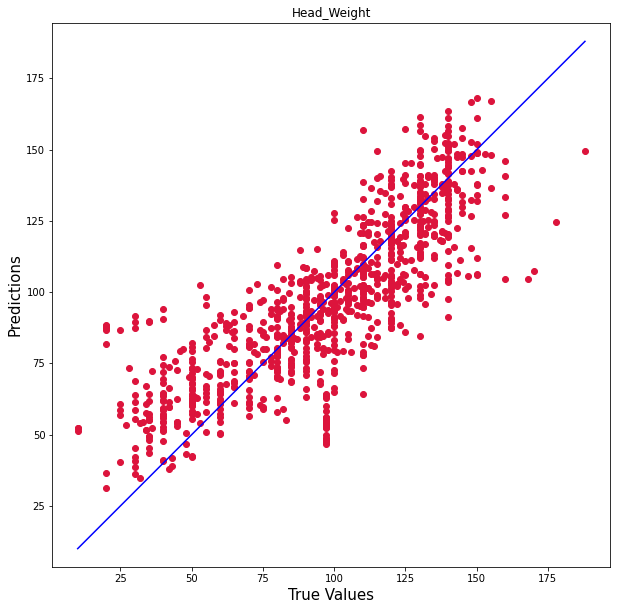

In [827]:
plot_fig(y_test.to_numpy().T[1], yhat.T[1], 'Head_Weight')


In [828]:
# k-nearest neighbors for multioutput regression

# create datasets
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=2, random_state=1, noise=0.5)
# define model
model_KNN = KNeighborsRegressor()
# fit model
model_KNN.fit(X_train, y_train)
# make a prediction
yhat = model_KNN.predict(X_test)
# summarize prediction by displaying first row
print('predicted response:', yhat, sep='\n')

predicted response:
[[144.  124.8 403.8]
 [140.  132.4 293.2]
 [ 85.   79.   84.2]
 ...
 [102.8 113.2  99.6]
 [ 82.6 105.   75.8]
 [146.  137.  384.2]]


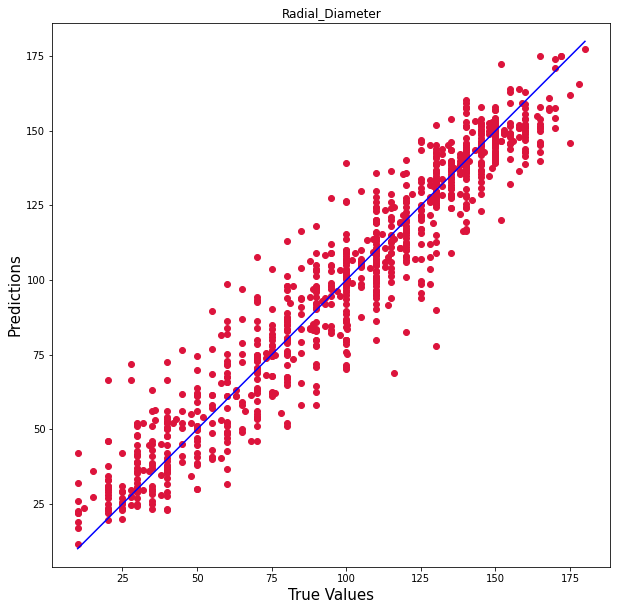

In [829]:
plot_fig(y_test.to_numpy().T[0], yhat.T[0],'Radial_Diameter')


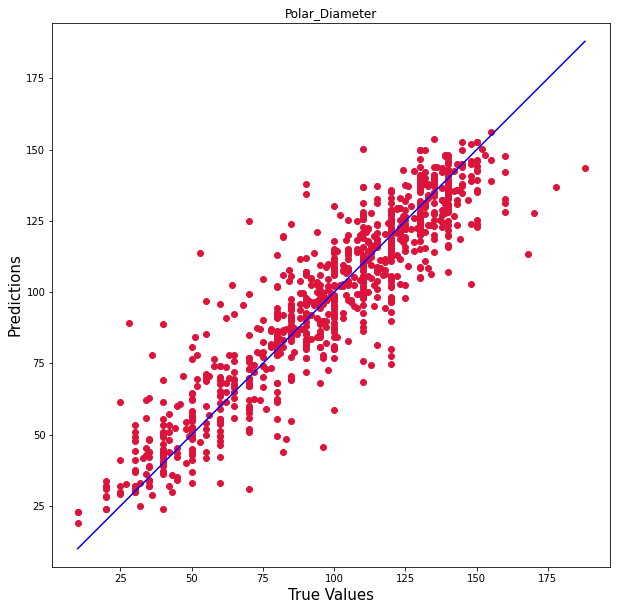

In [830]:
plot_fig(y_test.to_numpy().T[1], yhat.T[1], 'Polar_Diameter')


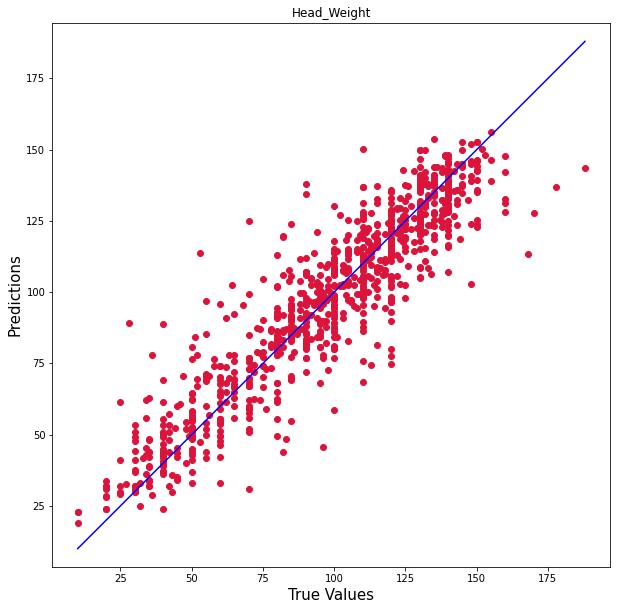

In [831]:
plot_fig(y_test.to_numpy().T[1], yhat.T[1], 'Head_Weight')


In [837]:
# decision tree for multioutput regression
# define model
model_dt = DecisionTreeRegressor()
# fit model
model_dt.fit(X_train, y_train)
# make a prediction
yhat = model_dt.predict(X_test)
# summarize prediction by displaying first row
print('predicted response:', yhat, sep='\n')

predicted response:
[[150. 130. 365.]
 [135. 138. 305.]
 [ 88.  80.  64.]
 ...
 [113. 110. 145.]
 [ 60.  72.  36.]
 [150. 140. 376.]]


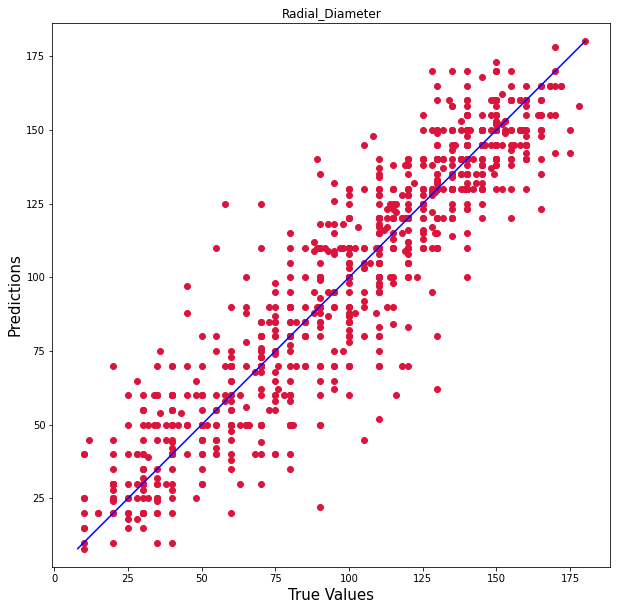

In [833]:
plot_fig(y_test.to_numpy().T[0], yhat.T[0],'Radial_Diameter')


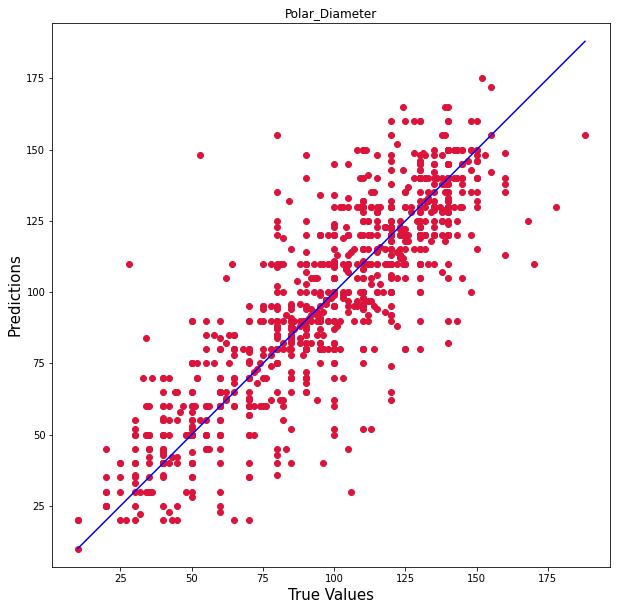

In [834]:
plot_fig(y_test.to_numpy().T[1], yhat.T[1], 'Polar_Diameter')


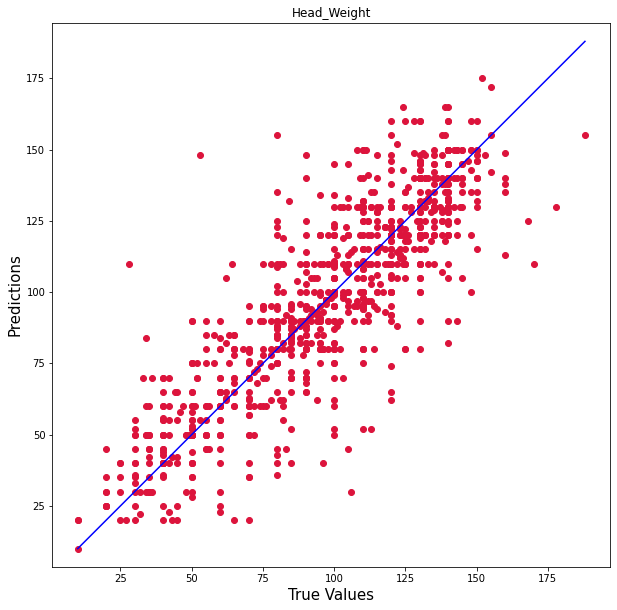

In [835]:
plot_fig(y_test.to_numpy().T[1], yhat.T[1], 'Head_Weight')


In [836]:
# evaluate multioutput regression model with k-fold cross-validation

# define the evaluation procedure
models = [(model_linear, 'Linear Regression'), (model_KNN, 'KNN'), (model_dt, 'Decision Tree')]
for model in models:
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    # evaluate the model and collect the scores
    n_scores = cross_val_score(model[0], X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force the scores to be positive
    n_scores = np.absolute(n_scores)
    # summarize performance
    print(model[1])
    print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    print('----------------------')

Linear Regression
MAE: 0.407 (0.021)
----------------------
KNN
MAE: 42.659 (3.052)
----------------------
Decision Tree
MAE: 51.660 (4.009)
----------------------
